In [ ]:
# %%

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from statsmodels.tsa.stattools import adfuller
from numpy.fft import fft
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error


# Carregar dados usando pandas
df = pd.read_csv('..\\Data\\Eletrobras ELET3 - Histórico  InfoMoney.csv')

# Converter virgulas para pontos e substituir n/d para NaN
for col in ['ABERTURA', 'FECHAMENTO', 'VARIAÇÃO', 'MÍNIMO', 'MÁXIMO']:
    df[col] = df[col].str.replace(",", ".").replace("n/d", np.nan).astype(float)

# Função para converter volume
def convert_volume(volume):
    if isinstance(volume, str):
      volume = volume.upper()
      if "M" in volume:
        return float(volume.replace("M", "").replace(",", ".")) * 1000000
      elif "B" in volume:
        return float(volume.replace("B", "").replace(",", ".")) * 1000000000
      else:
        return np.nan
    else:
        return np.nan

# Converter a coluna 'VOLUME'
df['VOLUME'] = df['VOLUME'].apply(convert_volume)

# Converter coluna data para data
df['DATA'] = pd.to_datetime(df['DATA'], dayfirst=True)

# Definir a data como indice
df = df.set_index('DATA')

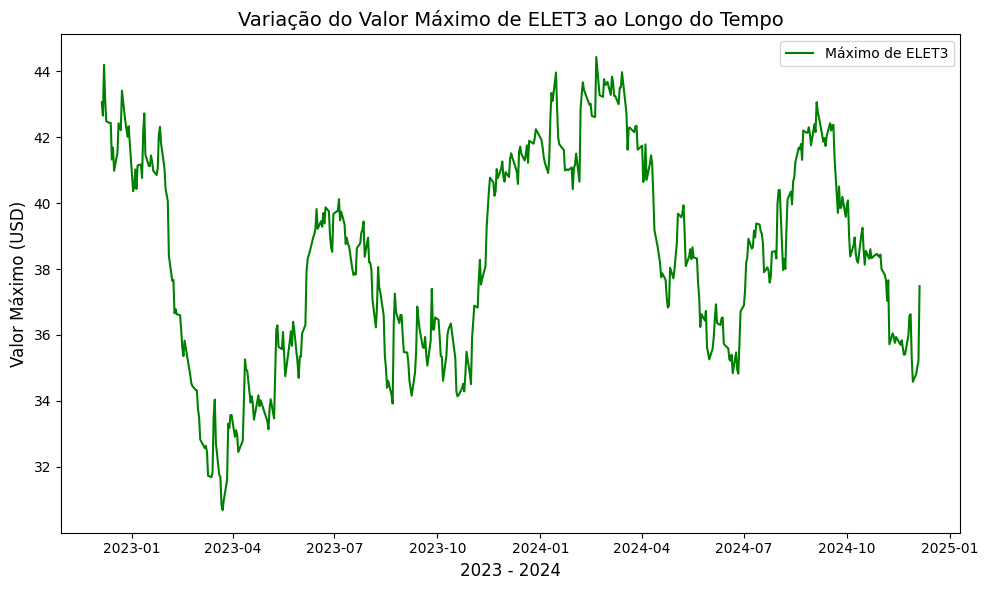

In [ ]:
# %%

# Gráfico da Série Original
plt.figure(figsize=(10, 6))
plt.plot(df.index, df['MÁXIMO'], linestyle='-', color='green', label='Máximo de ELET3')
plt.title('Variação do Valor Máximo de ELET3 ao Longo do Tempo', fontsize=14)
plt.xlabel('2023 - 2024', fontsize=12)
plt.ylabel('Valor Máximo (USD)', fontsize=12)
plt.legend()
plt.tight_layout()
plt.show()

# %% [markdown]

 ## **Remoção da Tendência da Série**

In [ ]:
# %%

def regressao_linear(x, y):
    x_sum = sum(x)
    y_sum = sum(y)
    x_sum2 = x_sum ** 2
    x2 = [xi ** 2 for xi in x]
    x2_sum = sum(x2)
    xy = [xi * yi for xi, yi in zip(x, y)]
    xy_sum = sum(xy)
    n = len(x)
    b1 = (x_sum * y_sum - n * xy_sum)  / (x_sum2 - n * x2_sum)
    b0 = (y_sum - b1 * x_sum) / n
    ym = [b0 + b1 * xi for xi in x]
    e2 = [(yi - ymi) ** 2 for yi, ymi in zip(y, ym)]
    e2_sum = sum(e2)
    y2 = [yi ** 2 for yi in y]
    y2_sum = sum(y2)
    y_sum2 = y_sum ** 2
    r2 = 1 - (e2_sum)/(y2_sum - y_sum2/n)
    return b0, b1, r2

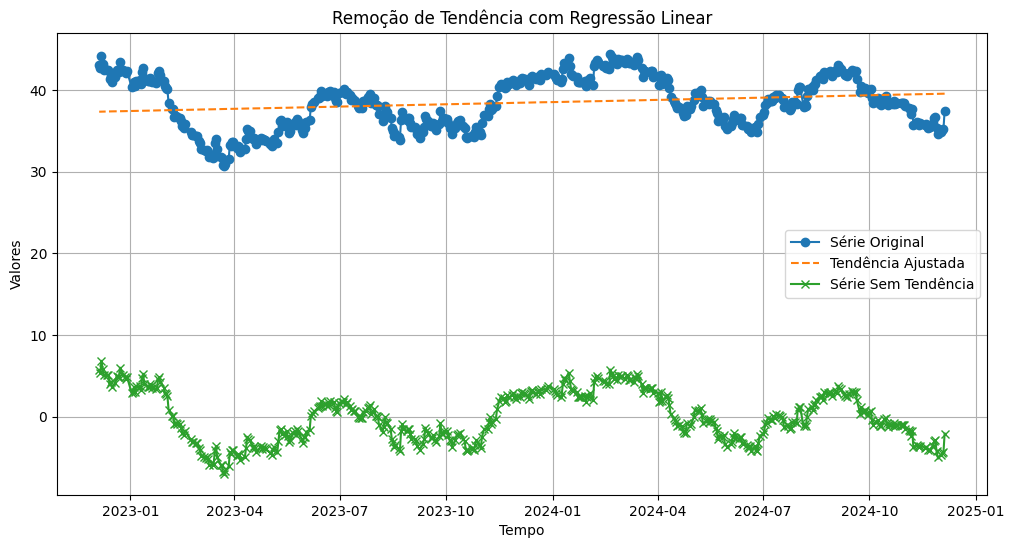

In [ ]:
# %%

# Utilizamos o indice do DataFrame para calcular a regressão
b0, b1, r2 = regressao_linear(range(len(df)), df['MÁXIMO'])

# Calcular valores ajustados (tendência)
tendencia = [b0 + b1 * xi for xi in range(len(df))]

# Remoção da tendência (resíduos)
serie_sem_tendencia = [yi - y_aj for yi, y_aj in zip(df['MÁXIMO'], tendencia)]
df['sem_tendencia'] = serie_sem_tendencia


# Visualização
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['MÁXIMO'], label="Série Original", marker="o")
plt.plot(df.index, tendencia, label="Tendência Ajustada", linestyle="--")
plt.plot(df.index, serie_sem_tendencia, label="Série Sem Tendência", marker="x")
plt.legend()
plt.title("Remoção de Tendência com Regressão Linear")
plt.xlabel("Tempo")
plt.ylabel("Valores")
plt.grid()
plt.show()

39.54063831297948
-0.004396418868689525
0.042439838784095296


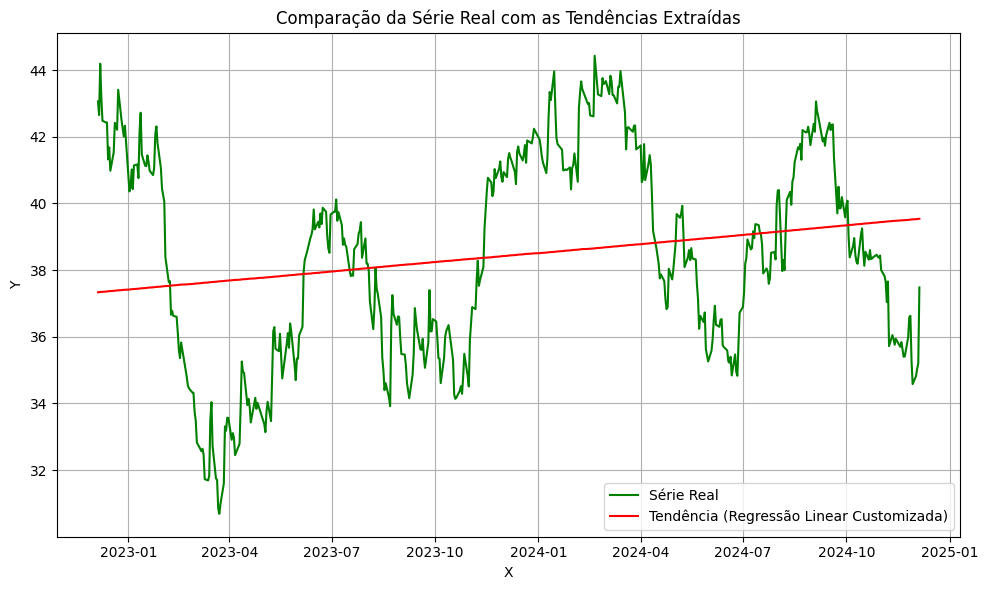


Dados com Tendências:
            ABERTURA  FECHAMENTO  VARIAÇÃO  MÍNIMO  MÁXIMO       VOLUME  \
DATA                                                                      
2024-12-05     34.71       36.46      4.02   36.17   37.48  939720000.0   
2024-12-04     34.55       35.05      0.31   34.46   35.20  613030000.0   
2024-12-03     34.29       34.94      1.22   34.37   35.04  666370000.0   
2024-12-02     34.29       34.52      0.44   34.28   34.82  301790000.0   
2024-11-29     33.97       34.37      0.94   33.96   34.58  894030000.0   
...              ...         ...       ...     ...     ...          ...   
2022-12-09     42.39       41.95     -0.77   41.75   42.48  580320000.0   
2022-12-08     42.76       42.27     -2.09   42.02   43.16  311210000.0   
2022-12-07     42.63       43.17      1.55   42.57   44.19  485610000.0   
2022-12-06     42.61       42.52      0.58   42.14   42.65  320430000.0   
2022-12-05     42.42       42.27     -2.25   41.74   43.06  599610000.0   

 

In [ ]:
# %%

X = range(len(df))
Y = df['MÁXIMO']

# Modelo linear por regressão linear
b0, b1, r2 = regressao_linear(X, Y)
print(b0)
print(b1)
print(r2)

# Curva usando modelo linear
ymodelo = [b0 + b1 * xi for xi in X]
df['Comp.Tendencia'] = ymodelo

# Série Real
plt.figure(figsize=(10, 6))
plt.plot(df.index, Y, label='Série Real', color='green')

# Tendência - Função Personalizada
plt.plot(df.index, ymodelo, 'r-', label='Tendência (Regressão Linear Customizada)')

plt.xlabel('X')
plt.ylabel('Y')
plt.title('Comparação da Série Real com as Tendências Extraídas')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print("\nDados com Tendências:")
print(df)

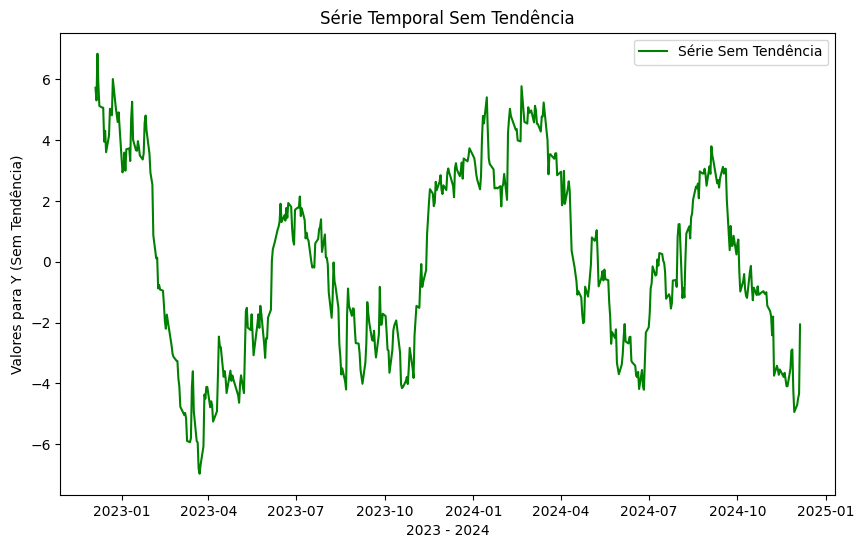

In [ ]:
# %%

plt.figure(figsize=(10, 6))
plt.plot(df.index, df['sem_tendencia'], label='Série Sem Tendência', color='green')
plt.xlabel('2023 - 2024')
plt.ylabel('Valores para Y (Sem Tendência)')
plt.title('Série Temporal Sem Tendência')
plt.legend()
plt.show()

In [ ]:
# %%

from statsmodels.tsa.stattools import adfuller

estacionaria = df['sem_tendencia']
adf_test = adfuller(estacionaria)
print("Teste ADF (Série Sem Tendência):")
print(f"ADF Statistic: {adf_test[0]}")
print(f"p-value: {adf_test[1]}")
if adf_test[1] < 0.05:
    print("A série sem tendência é estacionária.")
else:
    print("A série sem tendência não é estacionária. Diferenciação necessária.")

Teste ADF (Série Sem Tendência):
ADF Statistic: -1.9409573652518395
p-value: 0.31304542120491974
A série sem tendência não é estacionária. Diferenciação necessária.


# %% [markdown]

 **Calculando a Primeira Diferença**

In [ ]:
# %%

df['primeira_diferenca'] = df['sem_tendencia'].diff().dropna()

In [ ]:
# %%

df = df.dropna(subset=['primeira_diferenca'])

In [ ]:
# %%

estacionaria1 = df['primeira_diferenca']
adf_test = adfuller(estacionaria1)
print("Teste ADF (Primeira Diferença):")
print(f"ADF Statistic: {adf_test[0]}")
print(f"p-value: {adf_test[1]}")
if adf_test[1] < 0.05:
    print("A série diferenciada é estacionária.")
else:
    print("A série diferenciada não é estacionária. Diferenciação necessária.")

Teste ADF (Primeira Diferença):
ADF Statistic: -21.531991112819657
p-value: 0.0
A série diferenciada é estacionária.


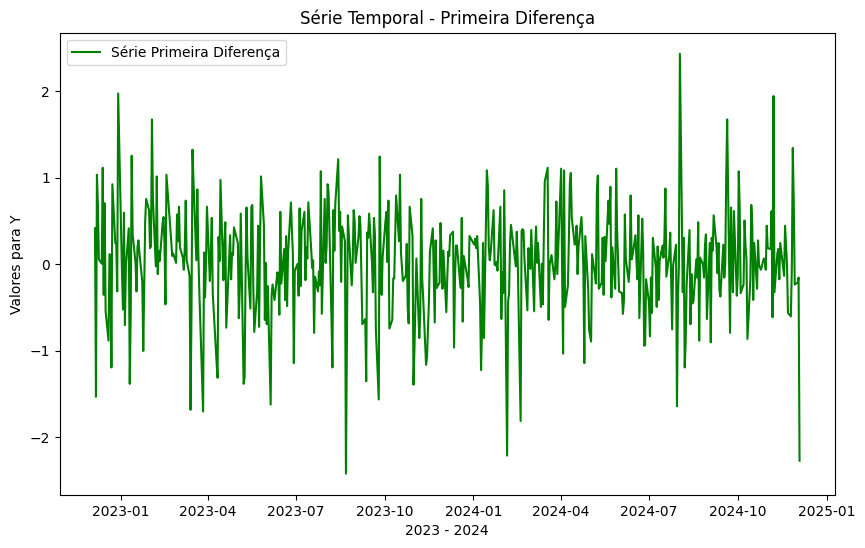

In [ ]:
# %%

plt.figure(figsize=(10, 6))
plt.plot(df.index, df['primeira_diferenca'], label='Série Primeira Diferença', color='green')
plt.xlabel('2023 - 2024')
plt.ylabel('Valores para Y')
plt.title('Série Temporal - Primeira Diferença')
plt.legend()
plt.show()

# %% [markdown]

 # **Aplicando a FFT**

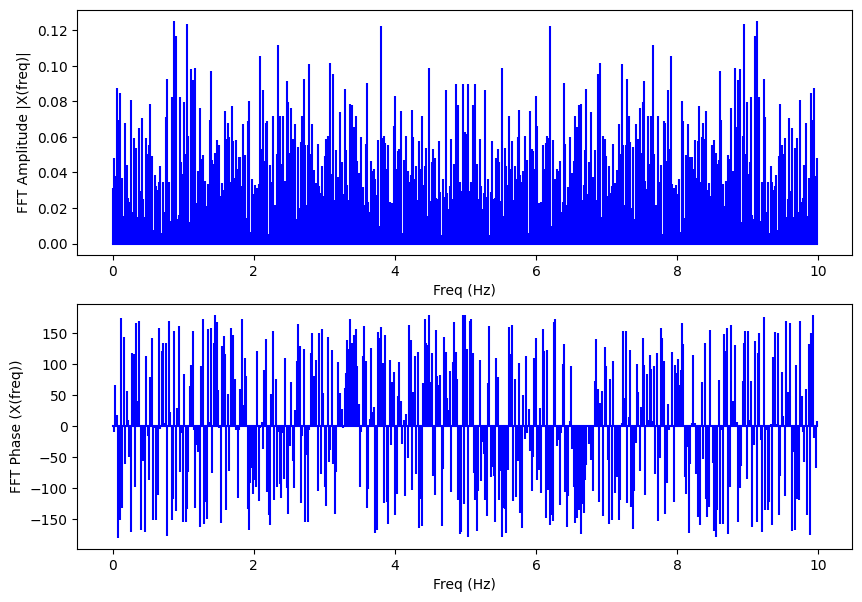

In [ ]:
# %%

dados = df['primeira_diferenca'].values
x = list(range(len(df)))

sr = 10
ts = 1.0 / sr
t = np.array(x)

X = fft(dados)
N = len(X)
n = np.arange(N)
T = N / sr
freqFft = n / T

amplitude = np.abs(X) / (N/2)
phase = np.angle(X, deg=True)
plt.figure(figsize=(10, 7))

plt.subplot(2,1,1)
plt.stem(freqFft, np.abs(X) / (N/2), 'b', \
         markerfmt=" ", basefmt="-b")
plt.xlabel('Freq (Hz)')
plt.ylabel('FFT Amplitude |X(freq)|')

plt.subplot(2,1,2)
plt.stem(freqFft, np.angle(X, deg=True), 'b', \
         markerfmt=" ", basefmt="-b")
plt.xlabel('Freq (Hz)')
plt.ylabel('FFT Phase (X(freq))')
plt.show()

In [ ]:
# %%

def find_high_amplitude_phase(ampli, phase, ffreq, threshold=0.124):
    high_amplitude_indices = np.where(ampli > threshold)
    high_amplitude_frequencies = ffreq[high_amplitude_indices]
    high_amplitude_phases = phase[high_amplitude_indices]
    ampli_indice = ampli[high_amplitude_indices]
    return high_amplitude_frequencies, high_amplitude_phases,  ampli_indice

valores = find_high_amplitude_phase(amplitude, phase, freqFft, threshold=0.124)

df_resultado = pd.DataFrame({
    "Frequência (Hz)": valores[0],
    "Fase (radianos)": valores[1],
    "Amplitude": valores[2]
})

# Exibindo a tabela
print("Frequências com amplitudes maiores que 0.124:")
print(df_resultado)

Frequências com amplitudes maiores que 0.124:
   Frequência (Hz)  Fase (radianos)  Amplitude
0         0.876494        154.43981   0.125301
1         9.123506       -154.43981   0.125301


In [ ]:
# %%

# Reconstrução da Série Usando FFT
fft_formula = ""
for i in range(len(valores[0])):
    amplitude_i = valores[2][i]
    frequency_i = valores[0][i]
    phase_i = valores[1][i]
    phase_rad = phase_i * (np.pi / 180)
    fft_formula += f"{amplitude_i:.6f} * np.cos(2 * np.pi * {frequency_i:.6f} * t - ({phase_rad:.6f})) + "
fft_formula = fft_formula.rstrip(" + ")  #

print("Fórmula Gerada:")
print(fft_formula)

try:
  X_fft = eval(fft_formula)
except SyntaxError as e:
    print(f"Erro de sintaxe na fórmula: {e}")
    X_fft = np.zeros(len(df))

Fórmula Gerada:
0.125301 * np.cos(2 * np.pi * 0.876494 * t - (2.695483)) + 0.125301 * np.cos(2 * np.pi * 9.123506 * t - (-2.695483))


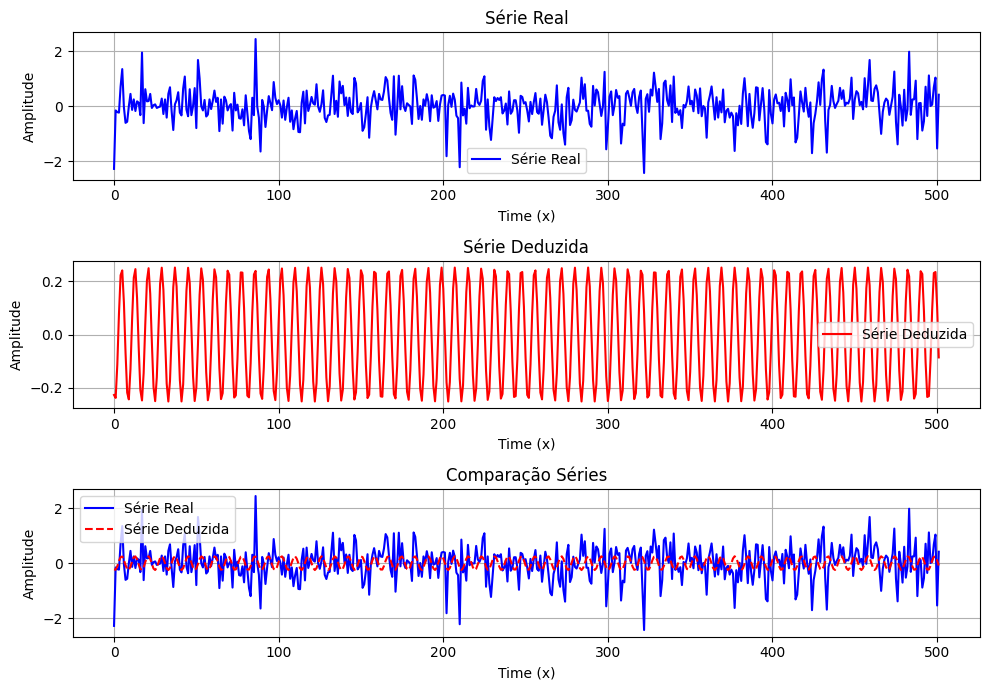

In [ ]:
# %%

X_real = df['primeira_diferenca'].values

fig, axs = plt.subplots(3, 1, figsize=(10, 7))

# Gráfico da série real
axs[0].plot(t, X_real, label='Série Real', color='blue')
axs[0].set_title('Série Real')
axs[0].set_xlabel('Time (x)')
axs[0].set_ylabel('Amplitude')
axs[0].legend()
axs[0].grid(True)

# Gráfico da série deduzida
axs[1].plot(t, X_fft, label='Série Deduzida', color='red')
axs[1].set_title('Série Deduzida')
axs[1].set_xlabel('Time (x)')
axs[1].set_ylabel('Amplitude')
axs[1].legend()
axs[1].grid(True)

# Gráfico comparativo entre a série real e deduzida
axs[2].plot(t, X_real, label='Série Real', color='blue')
axs[2].plot(t, X_fft, label='Série Deduzida', color='red', linestyle='--')
axs[2].set_title('Comparação Séries')
axs[2].set_xlabel('Time (x)')
axs[2].set_ylabel('Amplitude')
axs[2].legend()
axs[2].grid(True)
plt.tight_layout()
plt.show()

# %% [markdown]

  **APLICAÇÃO DOS MODELOS DE PREVISÃO - ARIMAX**

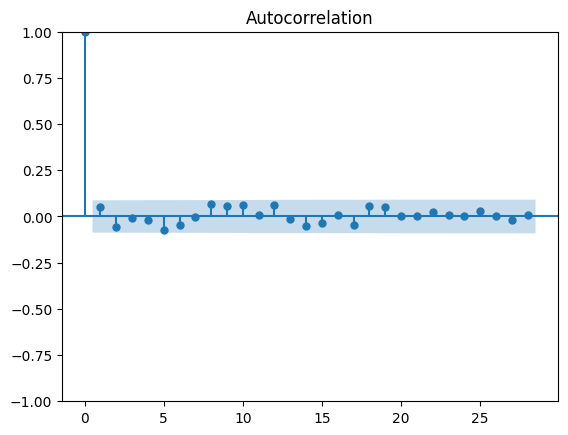

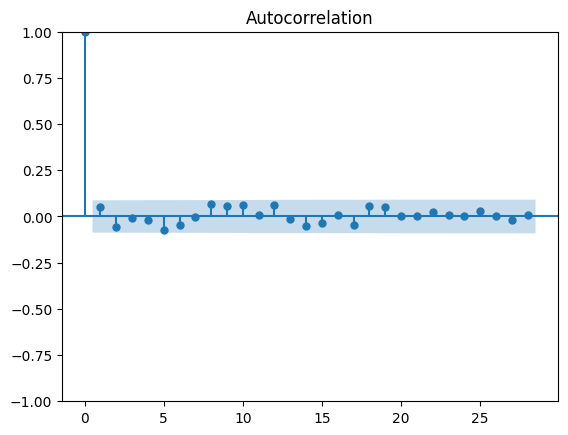

In [ ]:
# %%

plot_acf(df['primeira_diferenca'])

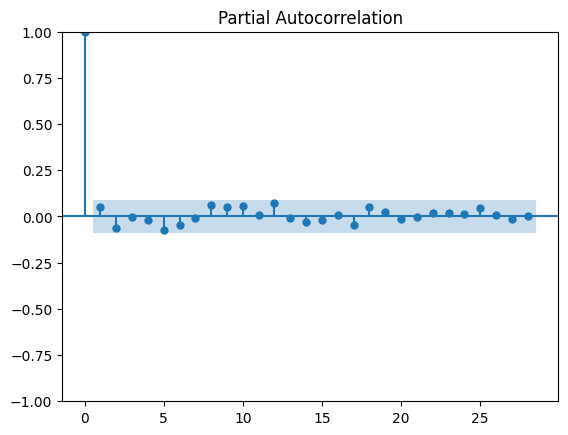

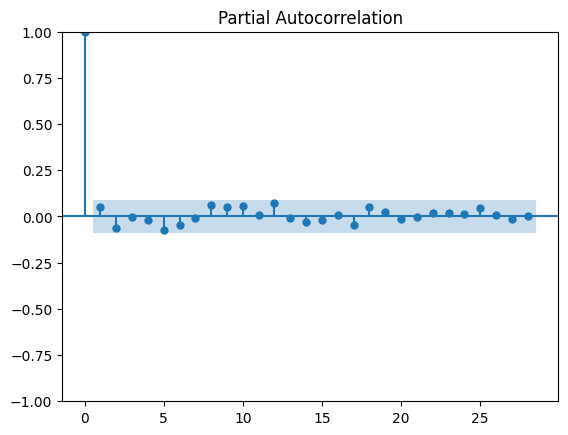

In [ ]:
# %%

plot_pacf(df['primeira_diferenca'])

<ipython-input-36-fee26a8e9adc>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_full[[f'{col}_lag_1' for col in features]] = df_full[features].shift(1)
<ipython-input-36-fee26a8e9adc>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_full[[f'{col}_lag_1' for col in features]] = df_full[features].shift(1)
<ipython-input-36-fee26a8e9adc>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cavea

ARIMAX RMSE: 0.14692058213575113


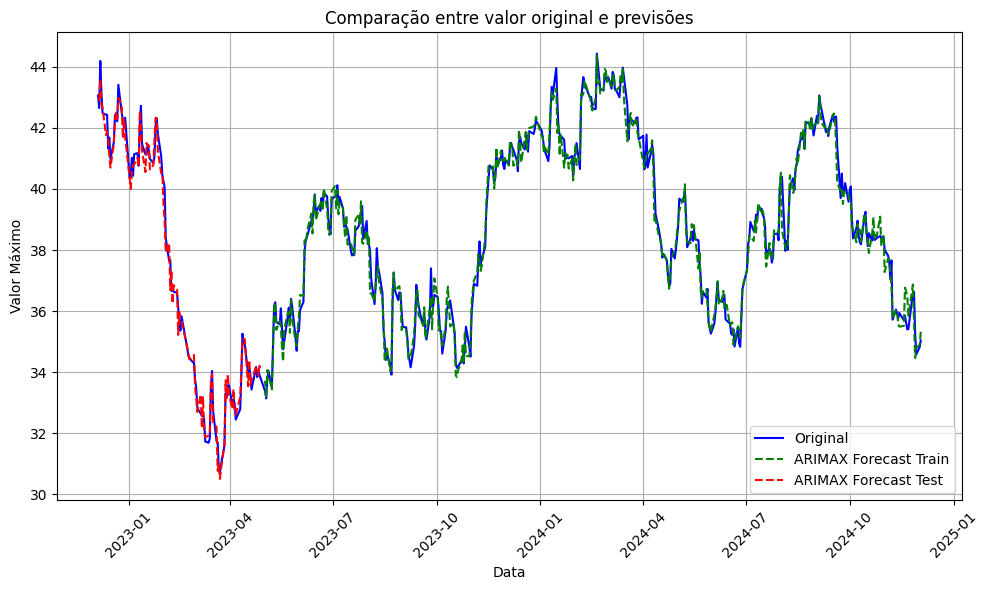

In [ ]:
# %%

# Definindo a variável alvo e as variáveis exógenas
target = 'MÁXIMO'
features = ['ABERTURA', 'FECHAMENTO', 'VARIAÇÃO', 'MÍNIMO', 'VOLUME']

# Remover NaN da serie
df_full = df.dropna(subset=[target] + features)

# Criar Lags das variáveis exógenas
df_full[[f'{col}_lag_1' for col in features]] = df_full[features].shift(1)
df_full = df_full.dropna()

# Separar dados
train_size = int(len(df_full) * 0.8)
train_data = df_full.iloc[:train_size]
test_data = df_full.iloc[train_size:]

# Normalização/Padronização
scaler_x = StandardScaler()
train_x = scaler_x.fit_transform(train_data[[f'{col}_lag_1' for col in features]])
test_x = scaler_x.transform(test_data[[f'{col}_lag_1' for col in features]])

scaler_y = StandardScaler()
train_y = scaler_y.fit_transform(train_data[target].values.reshape(-1,1)).flatten()
test_y = scaler_y.transform(test_data[target].values.reshape(-1,1)).flatten()

# 1. ARIMAX
order = (1, 0, 1)  # Define a ordem do modelo ARIMA
seasonal_order = (1, 1, 1, 4)  # Define a ordem da parte sazonal s=4
arimax_model = SARIMAX(train_y,
                       exog=train_x,
                       order=order,
                       seasonal_order=seasonal_order,
                       enforce_stationarity=False,
                       enforce_invertibility=False)
arimax_fit = arimax_model.fit()

arimax_predictions = arimax_fit.predict(start=0,
                                        end=len(train_y)-1,
                                        exog=train_x)

arimax_predictions_test = arimax_fit.predict(start=len(train_y),
                                                end=len(df_full)-1,
                                                exog=test_x)

arimax_predictions_desnormalized = scaler_y.inverse_transform(arimax_predictions.reshape(-1, 1)).flatten()
arimax_predictions_desnormalized_test = scaler_y.inverse_transform(arimax_predictions_test.reshape(-1, 1)).flatten()

arimax_rmse = np.sqrt(mean_squared_error(test_y, arimax_predictions_test))
print(f"ARIMAX RMSE: {arimax_rmse}")

# Exibir o gráfico com as previsões
plt.figure(figsize=(10, 6))
plt.plot(df_full.index, df_full[target], label='Original', color='blue')
plt.plot(train_data.index, arimax_predictions_desnormalized, label='ARIMAX Forecast Train', color='green', linestyle = '--')
plt.plot(test_data.index, arimax_predictions_desnormalized_test, label='ARIMAX Forecast Test', color='red', linestyle = '--')
plt.title('Comparação entre valor original e previsões')
plt.xlabel('Data')
plt.ylabel('Valor Máximo')
plt.grid(True)
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()